The transcription factor analyzed in this study is CTCF. 
Positive binding sites were obtained from ENCODE ChIP-seq narrowPeak files targeting CTCF in the GM12878 human lymphoblastoid cell line (genome build hg19).

In [1]:
%pip install Bio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


2026-01-06 00:21:25.629607: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-06 00:21:25.899459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-06 00:21:29.240189: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
def read_fasta(fasta_path, label):
    sequences = []
    with open(fasta_path, "r") as f:
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append((seq.upper(), label))
                    seq = ""
            else:
                seq += line
        if seq:
            sequences.append((seq.upper(), label))
    return sequences


# Read FASTA files
positive_seqs = read_fasta("positive_100.fa", label=1)
negative_seqs = read_fasta("negative_100.fa", label=0)

# Combine
all_data = positive_seqs + negative_seqs

# Create DataFrame
df = pd.DataFrame(all_data, columns=["Sequences", "Labels"])

# Shuffle (VERY important)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV
df.to_csv("genomics_data.csv", index=False)

print("CSV created: genomics_data.csv")
print(df.head())
print("\nClass distribution:")
print(df["Labels"].value_counts())


CSV created: genomics_data.csv
                                           Sequences  Labels
0  AGGTGAAGTTCTGCCCTCAGAGTGTGCCTTTCCCAGTTACTCCACT...       1
1  AGGGGCTGTAGATAATGTAATTGCAGCTATAGAATACAGAATGACT...       0
2  TATTATAAACTGGAGGAAAGGCCATCTTCATTATAAAGTGGCAAAG...       0
3  TCGAACCTACCATATAAGCTATATCTTTATTTTCCTTGTAATTTGG...       0
4  CTGGGCTTTTGAATGGTACAAGAAATAGAGAAGCCAAGGTCGCCCT...       1

Class distribution:
Labels
1    44982
0    44982
Name: count, dtype: int64


In [4]:
df["seq_len"] = df["Sequences"].str.len()
df["seq_len"].value_counts().head(10)


seq_len
100    89964
Name: count, dtype: int64

# Preprocess data
Since DNA is a sequence of non-numeric bases (i.e., A, C, T, G), we must first one-hot encode the sequences before they can be used as input to our deep learning model. 
Our CNN will then be able to learn to extract useful features from the sequences.

In [5]:
df["Sequences"] = df["Sequences"].str.replace("N", "A")


# Define a OneHotEncoder once for the DNA alphabet
# This ensures all sequences are encoded with the same 4 columns (A, C, G, T)
one_hot_encoder = OneHotEncoder(categories=[["A", "C", "G", "T"]], sparse_output=False)

# Fit the encoder on the full alphabet (just once)
one_hot_encoder.fit(np.array(["A", "C", "G", "T"]).reshape(-1, 1))

# Encode all sequences
input_features = []
for seq in df["Sequences"]:
    seq_array = np.array(list(seq)).reshape(-1, 1)  # Convert string to array of shape (50, 1)
    one_hot = one_hot_encoder.transform(seq_array)   # Shape (50, 4)
    input_features.append(one_hot)

# Convert list of arrays into a single 3D array: (num_sequences, 50, 4)
input_features = np.array(input_features)

# Labels
input_labels = df["Labels"].values.reshape(-1, 1)

print("Feature shape:", input_features.shape)
print("Label shape:", input_labels.shape)


Feature shape: (89964, 100, 4)
Label shape: (89964, 1)


In [6]:
df["Sequences"][0]

'AGGTGAAGTTCTGCCCTCAGAGTGTGCCTTTCCCAGTTACTCCACTAGATGGCCTTTCGCTTTAGGTAAAAAAAAGTTTTACAAAAGTAAAGTTTTCTAT'

In [7]:
# One-hot encoded: CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC

print(input_features[0])

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0.

# Split the data into train and test sets
We'll place 75% of the data (50604 sequences) into a training set. The remaining 25% (22491 sequences) will be placed into a test set for later evaluation. second split the training data to validation

In [8]:
# -------------------------------
# Train / validation / test split
# -------------------------------
# First: train + test
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features,
    input_labels,
    test_size=0.25,
    random_state=42,
    stratify=input_labels
)

# Step 2: split temp into validation (10%) and test (10%)
val_features, test_features, val_labels, test_labels = train_test_split(
    test_features,
    test_labels,
    test_size=0.50,
    random_state=42,
    stratify=test_labels
)



In [9]:
print(train_features.shape)
print(test_features.shape)

(67473, 100, 4)
(11246, 100, 4)


In [10]:
# -------------------------------
# Build CNN model
# -------------------------------
model = Sequential([

     ### DEEP LEARNING ###

    # Convolution & Pooling
    layers.Conv1D(filters=32, kernel_size=10, padding="same",
                  activation='relu', input_shape=(train_features.shape[1], 4)), # The length of the sequences.
    layers.MaxPooling1D(pool_size=4),

    # Fully-Connected Layer
    # Flatten the learned features into an array of values that are passed to the fully-connected layer.
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

# Compile the Model
model.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()



/home/kinya/miniconda3/envs/ann_bio/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-06 00:22:10.600533: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 32)        │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,145 (55.25 KB)

 Trainable params: 14,145 (55.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8134 - loss: 0.4058 - val_accuracy: 0.8699 - val_loss: 0.3108
Epoch 2/10
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8889 - loss: 0.2733 - val_accuracy: 0.8916 - val_loss: 0.2676
Epoch 3/10
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9071 - loss: 0.2356 - val_accuracy: 0.9085 - val_loss: 0.2328
Epoch 4/10
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9140 - loss: 0.2175 - val_accuracy: 0.9101 - val_loss: 0.2285
Epoch 5/10
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9198 - loss: 0.2049 - val_accuracy: 0.9133 - val_loss: 0.2236
Epoch 6/10
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9251 - loss: 0.1939 - val_accuracy: 0.9149 - val_loss: 0.2180
Epoch 7/10
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9291 - loss: 0.1842 - val_accuracy: 0.9152 - val_loss: 0.2259
Epoch 8/10
2109/2109 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9321 - loss: 0.

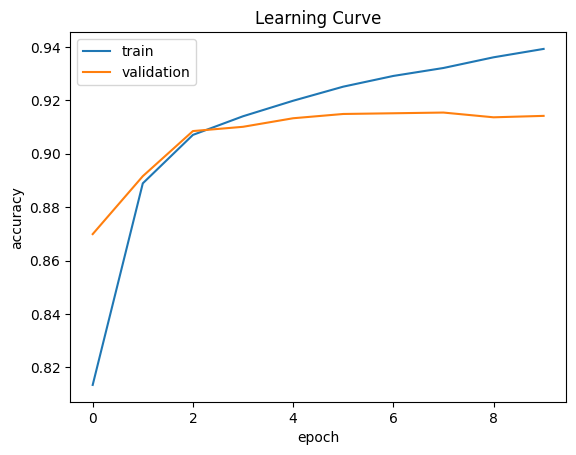

In [11]:
# -------------------------------
# Train model
# -------------------------------
from tensorflow.keras.callbacks import EarlyStopping

#monitor='val_loss' if validation acc is not improving stop to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
history = model.fit(train_features, train_labels,
                    epochs=10, validation_data=(val_features, val_labels),
                    batch_size=32)
# Visualize the learning curve
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Learning Curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation']);



We have set the number of epochs to 10, so the model goes through each of the sequences in the training set 10 times, learning as it goes.

The visualized learning curve displays how the model's accuracy and validation accuracy improve with each epoch.

The deep learning model appears to be quite effective in distinguishing sequences that bind the protein (have TFBS) from sequences that do not.

# Evaluate the model's performance on the test sequences

In [19]:
# -------------------------------
# Evaluate on test set
# -------------------------------
results = model.evaluate(test_features, test_labels, verbose=0)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

# Predict probabilities
y_pred = model.predict(test_features).ravel()

# Convert probabilities to classes
y_pred_class = (y_pred >= 0.5).astype(int)

# -------------------------------
# Classification report
# -------------------------------
target_names = [
    "Non-CTCF binding site",
    "CTCF binding site"
]

print("\nClassification Report:")
print(
    classification_report(
        test_labels,
        y_pred_class,
        target_names=target_names
    )
)

# -------------------------------
# ROC-AUC
# -------------------------------
roc_auc = roc_auc_score(test_labels, y_pred)
print("ROC-AUC:", roc_auc)


Test loss: 0.24112924933433533
Test accuracy: 0.9058331847190857
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
                       precision    recall  f1-score   support

Non-CTCF binding site       0.89      0.93      0.91      5623
    CTCF binding site       0.93      0.88      0.90      5623

             accuracy                           0.91     11246
            macro avg       0.91      0.91      0.91     11246
         weighted avg       0.91      0.91      0.91     11246

ROC-AUC: 0.9661756867397182


What DNA sequence patterns does the CNN use to decide that CTCF binds here?
Transcription factors bind specific DNA motifs

#We extracted convolutional filters from the first CNN layer and converted them into position weight matrices, 
#revealing sequence motifs consistent with transcription factor binding, 
#thereby demonstrating that the model learned biologically meaningful sequence features associated with CTCF binding.

EXtract first convolutional layer weights 
1st Conv learns Short sequence motifs (6–15 bp)

In [13]:
import numpy as np

# Get first convolutional layer
conv_layer = model.layers[0]

# Extract weights
# Shape: (kernel_length, 4, n_filters)
weights, biases = conv_layer.get_weights()

print(weights.shape)
#Kernel length → motif length
#4 channels → A, C, G, T
#Weight magnitude → base preference strength

(10, 4, 32)


convert the filter weights to Position Weight Matrices pwms (probabilities using softmax across A/C/G/T)
each position's probability P(A), P(C), P(G), P(T)
softmax so that:Values are between 0 and 1 and Probabilities at each position sum to 1

In [14]:
import scipy.special as sp

def filter_to_pwm(filter_weights):
    """
    Convert CNN filter to PWM using softmax
    """
    return sp.softmax(filter_weights, axis=1)

pwms = [filter_to_pwm(weights[:, :, i]) for i in range(weights.shape[2])]


In [15]:
%pip install logomaker


Note: you may need to restart the kernel to use updated packages.


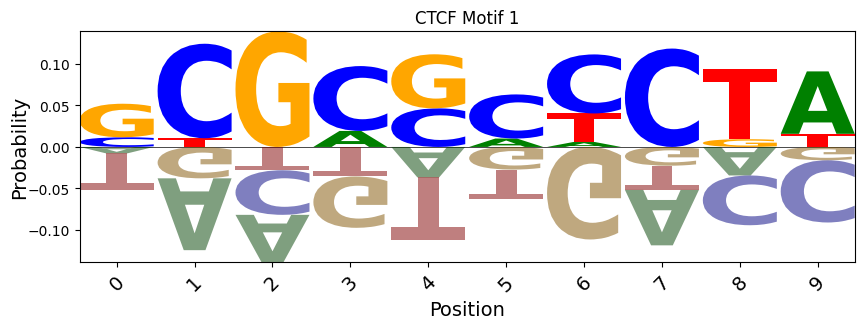

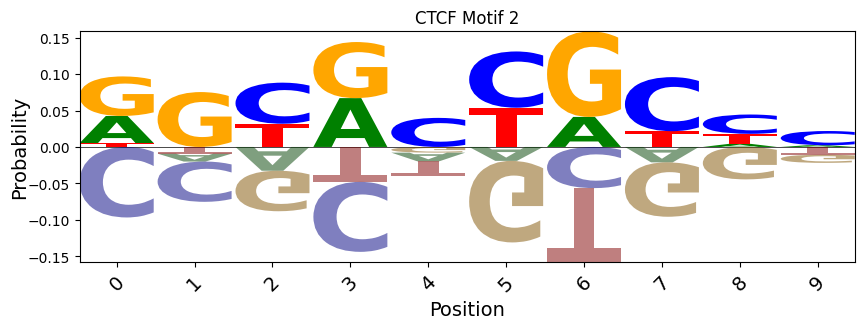

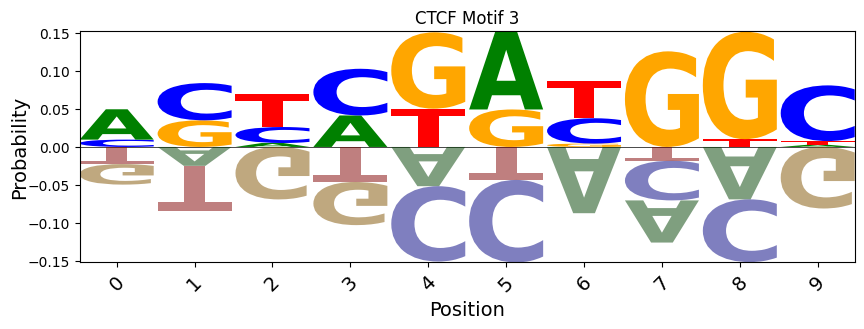

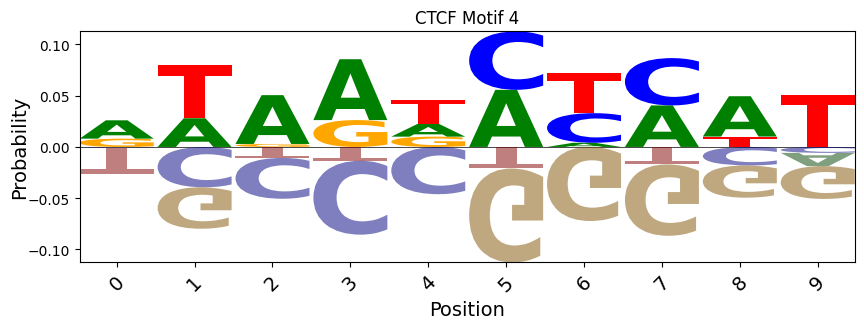

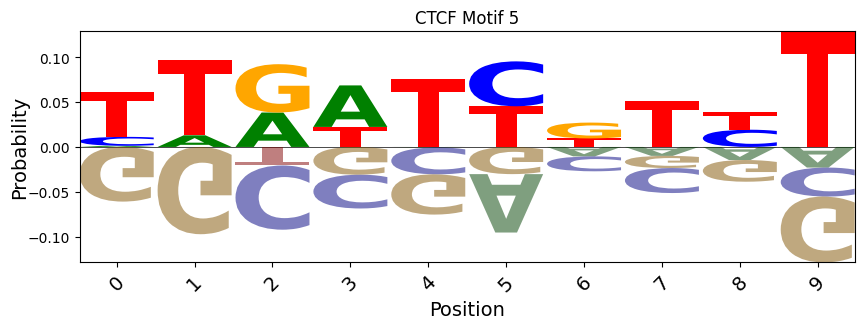

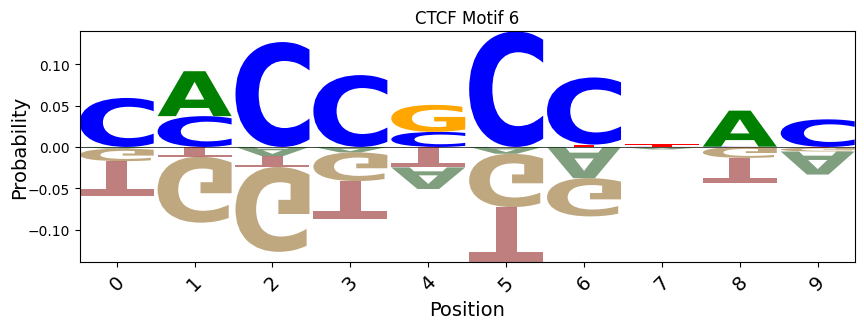

In [18]:
import logomaker as lm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
plt.ion()

bases = ["A", "C", "G", "T"]

for i, pwm in enumerate(pwms[:6]):  # show first 6 motifs
    df_pwm = pd.DataFrame(pwm, columns=bases)
    df_pwm.index.name = "pos"

    #plt.figure(figsize=(8, 2))
    logo = lm.Logo(df=df_pwm,
               font_name='DejaVu Sans',
               fade_below=0.5,
               shade_below=0.5,
               center_values=True,
               figsize=(10,3))
    logo.style_xticks(spacing=1, anchor=25, rotation=45, fmt='%d', fontsize=14)
    # set axes labels
    logo.ax.set_xlabel('Position',fontsize=14)
    logo.ax.set_ylabel("Probability", labelpad=-1,fontsize=14)
    
    #logomaker.Logo(df_pwm)
    plt.title(f"CTCF Motif {i+1}")
    #plt.xlabel("Position")
    #plt.ylabel("Probability")
    #plt.show()


In [17]:
df_pwm.head()

,A,C,G,T
pos,,,,
0,0.247982,0.309205,0.234814,0.207998
1,0.304268,0.287230,0.170212,0.238290
2,0.238967,0.376735,0.147451,0.236847
3,0.243439,0.336817,0.215342,0.204402
4,0.223869,0.268217,0.282588,0.225326
